We start with the Jeans equation for a spherical, static system in equilibrium. For a system with an isotropic velocity dispersion tensor $\sigma_r = \sigma_\theta = \sigma_\phi$, the Jeans equation simplifies to
\begin{equation}
    \frac{d}{dr}(\rho \sigma_r^2) = -\rho \frac{d\Phi}{dr}.
\end{equation}

We are looking for the total velocity dispersion squared $\sigma^2(r) = \langle v^2 \rangle$. Due to isotropy, we have $\langle v^2 \rangle = 3\sigma_r^2$.

Recall the enclosed mass $M(r) = M \frac{r^3}{(r+a)^3}$. The gravitational acceleration is
\begin{equation}
    -\frac{d\Phi}{dr} = -\frac{GM(r)}{r^2} = -\frac{GM r}{(r+a)^3}.
\end{equation}
Substitute the density $\rho(r) = \frac{3Ma}{4\pi(r+a)^4}$ and the force into the Jeans equation
\begin{align}
    \frac{d}{dr}(\rho \sigma_r^2)
    &= - \left( \frac{3Ma}{4\pi(r+a)^4} \right) \left( \frac{GM r}{(r+a)^3} \right) \\
    &= - \frac{3G M^2 a}{4\pi} \frac{r}{(r+a)^7}.
\end{align}
To find the pressure $\rho \sigma_r^2$, we integrate from $r$ to $\infty$ and use the substitution $u = r' + a$,
\begin{align}
    \rho \sigma_r^2
    &= \frac{3G M^2 a}{4\pi} \int_r^{\infty} \frac{r'}{(r'+a)^7} \,dr' \\
    &= \frac{3G M^2 a}{4\pi} \int_r^\infty (u^{-6} - a u^{-7}) \,du \\
    &= \frac{3G M^2 a}{4\pi}\left(0 - \left[ -\frac{1}{5(r+a)^5} + \frac{a}{6(r+a)^6} \right]\right) \\
    &= \frac{3G M^2 a}{4\pi} \cdot \frac{6r + a}{30(r+a)^6}
\end{align}
Divide by $\rho = \frac{3Ma}{4\pi(r+a)^4}$ to obtain
\begin{align}
    \sigma_r^2
    &= \left( \frac{3G M^2 a}{4\pi} \frac{6r+a}{30(r+a)^6} \right) \left( \frac{4\pi(r+a)^4}{3Ma} \right) \\
    &= \frac{GM(6r+a)}{30(r+a)^2} \\
\end{align}
Finally, since $\sigma^2(r) = 3\sigma_r^2$, we get
\begin{equation}
    \sigma^2(r) = \frac{GM(6r+a)}{10(r+a)^2}.
\end{equation}

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def get_potential_psi(r):
    return (2 * r + 1) / (2 * (r + 1)**2)

def analytic_f(epsilon):
    eps = np.clip(epsilon, 0.0, 0.4999999)
    denom = 1.0 - 2.0 * eps
    term1 = ((3.0 - 4.0 * eps) * np.sqrt(2.0 * eps)) / denom
    term2 = 3.0 * np.arcsinh(np.sqrt((2.0 * eps) / denom))
    return np.where(epsilon <= 0, 0.0, (3.0 / (2.0 * np.pi**3)) * (term1 - term2))

def analytic_sigma2(r):
    return (1 * (1 + 6*r)) / (10 * (r + 1)**2)

def generate_system(N=10000, r_trunc=100):
    np.random.seed(42)
    # Rejection sampling scalar r, v
    particles_r, particles_v = [], []
    while len(particles_r) < N:
        r = np.random.uniform(0, r_trunc, N)
        v = np.random.uniform(0, 1.0, N)
        psi = get_potential_psi(r)
        eps = psi - 0.5 * v**2
        mask = (eps > 0) & (eps < 0.5)
        r, v, eps = r[mask], v[mask], eps[mask]
        w = (r**2) * (v**2) * analytic_f(eps)
        if len(r) > 0:
            accept = np.random.uniform(0, 1, len(r)) < (w / 0.0035)
            particles_r.extend(r[accept])
            particles_v.extend(v[accept])

    # Isotropy
    r_scalar = np.array(particles_r[:N])
    v_scalar = np.array(particles_v[:N])

    def random_sphere(n):
        u1, u2 = np.random.random(n), np.random.random(n)
        phi, costheta = 2*np.pi*u1, 2*u2-1
        sintheta = np.sqrt(1 - costheta**2)
        return np.column_stack((sintheta*np.cos(phi), sintheta*np.sin(phi), costheta))

    pos = random_sphere(N) * r_scalar[:, np.newaxis]
    vel = random_sphere(N) * v_scalar[:, np.newaxis]
    masses = np.ones(N) * (1.0/N)

    return pos, vel, masses

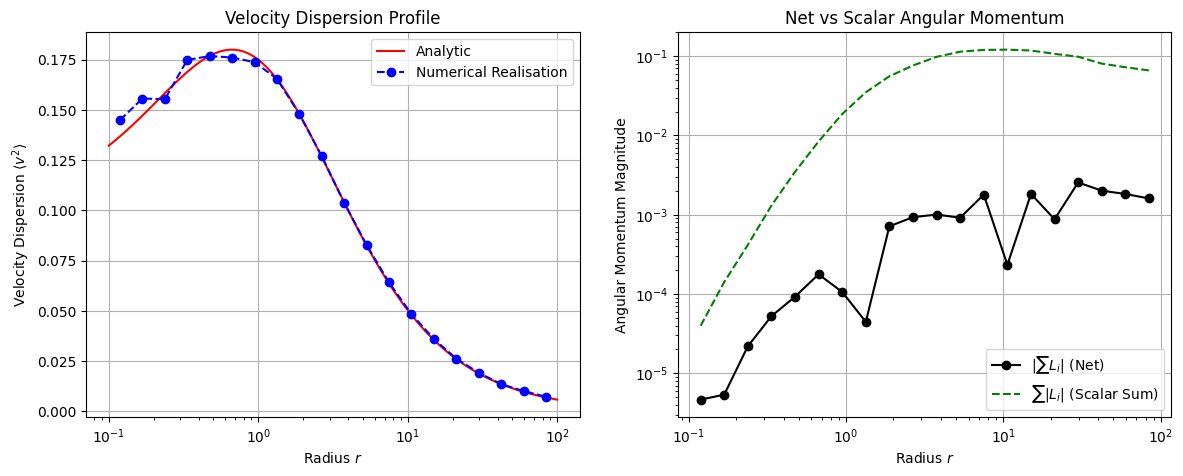

Total Net Angular Momentum of System: 3.81e-03
Average Ratio (Net L / Scalar L) across bins: 0.0243


In [19]:
N_PARTICLES = 100000
pos, vel, m = generate_system(N_PARTICLES)
radii = np.linalg.norm(pos, axis=1)
v_squared = np.sum(vel**2, axis=1)
# Calculate Angular Momentum L = m (r x v)
# We use mass=1/N for physical magnitude, or r x v for specific L
L_vec = np.cross(pos, vel) * m[:, np.newaxis]

n_bins = 20
bin_edges = np.logspace(-1, 2, n_bins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

numerical_sigma2 = []
net_L_magnitude = []
sum_L_magnitude = []

for i in range(n_bins):
    mask = (radii >= bin_edges[i]) & (radii < bin_edges[i+1])
    if np.sum(mask) > 5:
        # Dispersion: Mean of v^2
        numerical_sigma2.append(np.mean(v_squared[mask]))

        # Angular Momentum
        # Sum of vectors L in this bin
        L_sum_vec = np.sum(L_vec[mask], axis=0)
        net_L_magnitude.append(np.linalg.norm(L_sum_vec))

        # Sum of magnitudes (scalar) to compare against
        sum_L_magnitude.append(np.sum(np.linalg.norm(L_vec[mask], axis=1)))
    else:
        numerical_sigma2.append(np.nan)
        net_L_magnitude.append(np.nan)
        sum_L_magnitude.append(np.nan)

r_grid = np.logspace(-1, 2, 100)
sigma2_theory = analytic_sigma2(r_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(r_grid, sigma2_theory, 'r-', label=r'Analytic')
ax1.plot(bin_centers, numerical_sigma2, 'bo--', label='Numerical Realisation')
ax1.set_xscale('log')
ax1.set_xlabel('Radius $r$')
ax1.set_ylabel(r'Velocity Dispersion $\langle v^2 \rangle$')
ax1.set_title('Velocity Dispersion Profile')
ax1.legend()
ax1.grid(True)


ratio_L = np.array(net_L_magnitude) / np.array(sum_L_magnitude)
ax2.plot(bin_centers, net_L_magnitude, 'k-o', label=r'$|\sum L_i|$ (Net)')
ax2.plot(bin_centers, sum_L_magnitude, 'g--', label=r'$\sum |L_i|$ (Scalar Sum)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Radius $r$')
ax2.set_ylabel('Angular Momentum Magnitude')
ax2.set_title('Net vs Scalar Angular Momentum')
ax2.legend()
ax2.grid(True)

plt.show()

print(f"Total Net Angular Momentum of System: {np.linalg.norm(np.sum(L_vec, axis=0)):.2e}")
print(f"Average Ratio (Net L / Scalar L) across bins: {np.nanmean(ratio_L):.4f}")

Numerically, the realisation will have a very small, non-zero net angular momentum. The magnitude of the net vector sum $|\sum L_i|$ is several orders of magnitude lower than the sum of the individual angular momentum magnitudes $\sum |L_i|$. The non-zero value is due to Poisson noise inherent in Monte-Carlo sampling with a finite number of particles.

The theoretical distribution function $f(\epsilon)$ depends only on the energy $\epsilon$. It does not depend on the angular momentum vector $L$ or its components. Furthermore, the system is constructed to be spherically symmetric and isotropic. We generated the velocity vectors $v$ by choosing random directions uniformly on a sphere, independent of position. Therefore, the macroscopic system is non-rotating and should show zero net angular momentum.

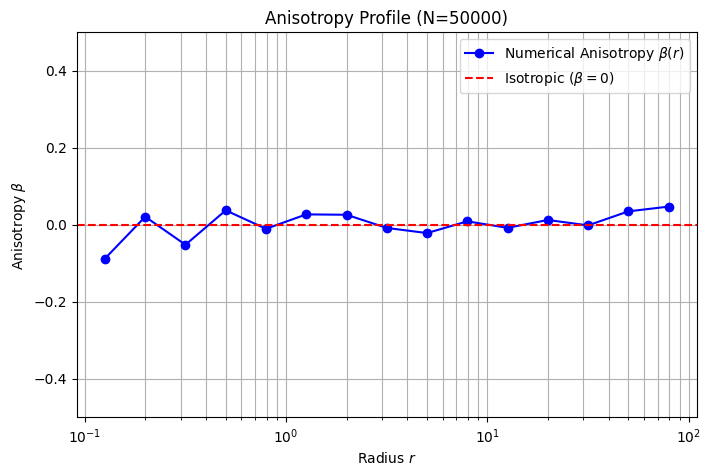

Mean Anisotropy across bins: 0.0013


In [21]:
N = 50000
pos, vel, _ = generate_system(N, r_trunc=100)

radii = np.linalg.norm(pos, axis=1)

# Radial velocity v_r = (v . x) / r
v_dot_x = np.sum(vel * pos, axis=1)
vr = v_dot_x / radii
# Squared velocities
vr_sq = vr**2
v_tot_sq = np.sum(vel**2, axis=1)
# Tangential velocity squared v_t^2 = v^2 - v_r^2
vt_sq = v_tot_sq - vr_sq

# Binning
n_bins = 15
bin_edges = np.logspace(-1, 2, n_bins + 1) # 0.1 to 100
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

beta_list = []
r_plot = []

for i in range(n_bins):
    mask = (radii >= bin_edges[i]) & (radii < bin_edges[i+1])
    if np.sum(mask) > 50:
        mean_vr2 = np.mean(vr_sq[mask])
        mean_vt2 = np.mean(vt_sq[mask])

        # Anisotropy: beta = 1 - <vt^2> / (2 * <vr^2>)
        beta = 1.0 - mean_vt2 / (2.0 * mean_vr2)
        beta_list.append(beta)
        r_plot.append(bin_centers[i])

plt.figure(figsize=(8, 5))

plt.plot(r_plot, beta_list, 'o-', color='blue', label=r'Numerical Anisotropy $\beta(r)$')
plt.axhline(0, color='red', linestyle='--', label=r'Isotropic ($\beta=0$)')
plt.xscale('log')
plt.xlabel('Radius $r$')
plt.ylabel('Anisotropy $\\beta$')
plt.title(f'Anisotropy Profile (N={N})')
plt.ylim(-0.5, 0.5)
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f"Mean Anisotropy across bins: {np.mean(beta_list):.4f}")

The anisotropy is defined as
\begin{equation}
    \beta(r) = 1 - \frac{\langle v_t^2 \rangle}{2\langle v_r^2 \rangle},
\end{equation}
where $\langle v_t^2 \rangle = \langle v^2 \rangle - \langle v_r^2 \rangle$ and $\langle v_r^2 \rangle = \langle (v \cdot x/r)^2 \rangle$.

The system should be isotropic $\beta = 0$. This is because the distribution function $f(\epsilon)$ depends only on the binding energy $\epsilon$. It does not depend on the angular momentum vector $L$.

In spherical systems, if the distribution function is of the form $f = f(\epsilon)$, then the velocity distribution at any point is isotropic. This means that the dispersion in the radial direction $\sigma_r$ is equal to the dispersion in the tangential directions $\sigma_\theta$ and $\sigma_\phi$. Therefore, $\langle v_r^2 \rangle = \sigma_r^2$ and $\langle v_t^2 \rangle = \langle v_\theta^2 \rangle + \langle v_\phi^2 \rangle = 2\sigma_r^2$, which in the anisotropy formula yields
\begin{equation}
    \beta = 1 - \frac{\langle v_t^2 \rangle}{2\langle v_r^2 \rangle} = 1 - \frac{2\sigma_r^2}{2\sigma_r^2} = 0.
\end{equation}

In the numerical simulation, we observe some noise away from $0$. This is not true physical anisotropy and manifests because of statistical variance. The average over all bins should be close to $0$.

---

Assuming the system is spherically symmetric, the gravitational potential $\Phi(r_i)$ at the position of the $i$-th particle (sorted by radius) is determined by the contribution of all other spherical shells
\begin{equation}
    \Phi(r_i) = -G \left( \frac{M(< r_i)}{r_i} + \int_{r_i}^{\infty} \frac{dM}{r} \right).
\end{equation}
In discrete form, for particles sorted by radius $r_1 < r_2 < \dots < r_N$, this truncates to
\begin{equation}
    \Phi(r_i) \approx - \sum_{j=1}^{i} \frac{G m_j}{r_i} - \sum_{j=i+1}^{N} \frac{G m_j}{r_j}.
\end{equation}
The first term represents the interior mass acting as a point mass at the center. The second term represents the constant potential contribution from shells exterior to $r_i$.

The local escape speed is defined as the velocity required to escape the potential well from radius $r$ to infinity
\begin{equation}
    v_{\text{escape}}(r) = \sqrt{-2\Phi(r)}.
\end{equation}
For a bound system in equilibrium, the typical squared velocity $\langle v^2 \rangle$ must be less than $v_{\text{escape}}^2$.

In [23]:
def analytic_potential(r, G=1, M=1, a=1):
    return - (G * M * (2 * r + a)) / (2 * (r + a)**2)

def analytic_dispersion_sq(r, G=1, M=1, a=1):
    return (G * M * (a + 6 * r)) / (10 * (r + a)**2)

def get_potential_psi(r):
    return (2 * r + 1) / (2 * (r + 1)**2)


def generate_realisation(N, q_max=0.002, r_trunc=100):
    np.random.seed(42)
    particles_r = []
    particles_v = []

    while len(particles_r) < N:
        batch = N
        r = np.random.uniform(0, r_trunc, batch)
        v = np.random.uniform(0, 1.0, batch)

        psi = get_potential_psi(r)
        eps = psi - 0.5 * v**2
        mask = (eps > 0) & (eps < 0.5)

        r, v, eps = r[mask], v[mask], eps[mask]

        if len(r) == 0: continue

        w = (r**2) * (v**2) * analytic_f(eps)
        if np.any(w > q_max):
            q_max = np.max(w) * 1.1

        accept = np.random.uniform(0, 1, len(r)) < (w / q_max)
        particles_r.extend(r[accept])
        particles_v.extend(v[accept])

    # Truncate and Mass
    r_out = np.array(particles_r[:N])
    v_out = np.array(particles_v[:N])
    m_out = np.ones(N) * (1.0 / N)

    return r_out, v_out, m_out

def calculate_numerical_potential(r, m):
    '''
    Calculates Phi(r) assuming spherical symmetry using the discrete
    shell approximation.
    '''
    # Sort particles by radius
    order = np.argsort(r)
    r_sorted = r[order]
    m_sorted = m[order]

    # Potential from interior mass
    mass_inside = np.cumsum(m_sorted)
    phi_interior = - (mass_inside) / r_sorted

    # Potential from exterior mass (acting as shells)
    inv_r = 1.0 / r_sorted
    potential_sum_ext = np.cumsum((m_sorted * inv_r)[::-1])[::-1]

    potential_sum_ext -= (m_sorted * inv_r)
    phi_exterior = - potential_sum_ext
    phi_total = phi_interior + phi_exterior

    return r_sorted, phi_total

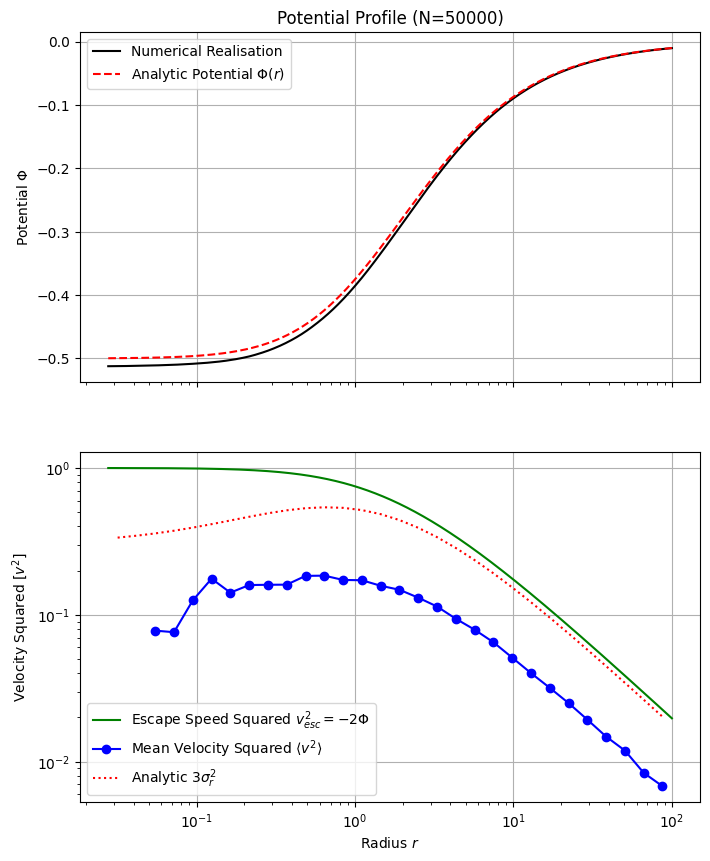

In [34]:
N_particles = 50000
r, v, m = generate_realisation(N_particles)

# Potential Comparison
r_sorted, phi_num = calculate_numerical_potential(r, m)
phi_an = analytic_potential(r_sorted)
# Escape Speed vs Mean Squared Velocity
v_esc_sq = -2 * phi_an

# Binning
n_bins = 30
bin_edges = np.logspace(np.log10(np.min(r)), np.log10(np.max(r)), n_bins+1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
v_mean_sq = []

for i in range(n_bins):
    mask = (r >= bin_edges[i]) & (r < bin_edges[i+1])
    if np.sum(mask) > 5:
        v_mean_sq.append(np.mean(v[mask]**2))
    else:
        v_mean_sq.append(np.nan)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

ax1.plot(r_sorted, phi_num, 'k-', label='Numerical Realisation')
ax1.plot(r_sorted, phi_an, 'r--', label=r'Analytic Potential $\Phi(r)$')
ax1.set_ylabel(r'Potential $\Phi$')
ax1.set_title(f'Potential Profile (N={N_particles})')
ax1.legend()
ax1.grid(True)

ax2.plot(r_sorted, v_esc_sq, 'g-', label=r'Escape Speed Squared $v_{esc}^2 = -2\Phi$')
ax2.plot(bin_centers, v_mean_sq, 'bo-', label=r'Mean Velocity Squared $\langle v^2 \rangle$')
sigma2_an = analytic_dispersion_sq(bin_centers)
ax2.plot(bin_centers, 3*sigma2_an, 'r:', label=r'Analytic $3\sigma_r^2$') # 3*sigma_r^2 = <v^2>

ax2.set_xlabel('Radius $r$')
ax2.set_ylabel('Velocity Squared $[v^2]$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)

plt.show()

The numerical potential closely tracks the analytic potential. At very small radii, the numerical potential may show noise or deviations. This is because the enclosed mass calculation relies on the few particles present in the core, making it sensitive to statistical fluctuations. At large radii, the fit is typically very smooth.

The escape speed squared is consistently higher than the mean squared velocity . This confirms the system is gravitationally bound. If particles typically had $\langle v^2 \rangle \ge v_{\text{esc}}^2$, then the galaxy would fly apart. At large radii both decay as $\sim 1/r$.

*   For low $N$, the potential profile will appear jagged rather than smooth. The binned velocity dispersion will fluctuate wildly, especially in the outer halo where bin counts are low.
*   For high $N$ The potential profile becomes smooth and more accurate. The velocity dispersion bins stabilise, reducing the scatter around the theoretical prediction. Increasing $N$ reduces the Poisson noise which is proportional to $1/\sqrt{N}$.